In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing libraries for data preprocessing and modelling
from sklearn.model_selection import train_test_split  # for splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder  # for label encoding the target variable
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score  # for evaluating model performance
from sklearn.metrics import classification_report  # for printing the classification report
from sklearn.metrics import confusion_matrix  # for calculating and printing confusion matrix
from tensorflow.keras.models import Sequential  # for creating sequential neural network models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional  # for adding layers to the model
from tensorflow.keras.preprocessing.text import Tokenizer  # for converting text to numerical sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  # for padding sequences with zeros
from tensorflow.keras.utils import to_categorical  # for one-hot encoding the target variable
from tensorflow.keras.optimizers import Adam  # for setting the optimizer for the model
from transformers import TFBertModel, BertTokenizer  # for using pre-trained BERT model
from nltk.corpus import stopwords  # for removing stop words from text data
from nltk.tokenize import word_tokenize  # for tokenizing text data
from nltk.stem import WordNetLemmatizer  # for lemmatizing text data
from wordcloud import WordCloud  # for visualizing the most frequent words in text data
import re  # for regular expressions used in text preprocessing
from tensorflow.keras.callbacks import Callback
import time
import nltk

In [2]:
# Load the Amazon Kindle Book Reviews datasetfor processing
amazon_kindle_review = pd.read_csv('Amazon_Kindle_Review.csv') 

In [3]:
#save a copy od the raw data
df = amazon_kindle_review.copy()

In [4]:
df = df[['reviewText', 'rating']] # capturing necessary colums

In [5]:
#inspecting the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  12000 non-null  object
 1   rating      12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


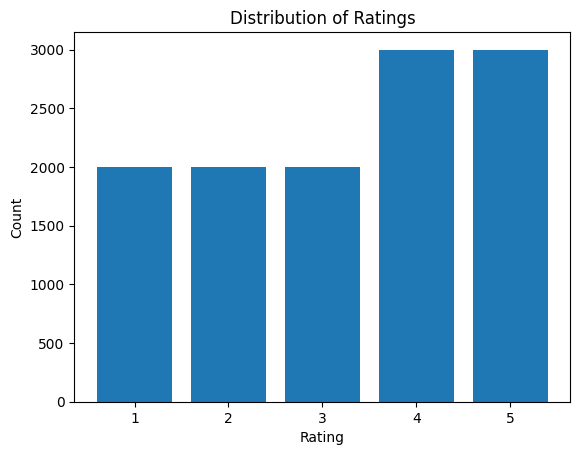

In [43]:
# Count the number of occurrences of each rating
rating_counts = df['rating'].value_counts()

# Plot a bar chart of the counts
plt.bar(rating_counts.index, rating_counts.values)

# Set the axis labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Show the plot
plt.show()

In [6]:
df[:2] #check the data

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5


In [7]:
def remove_tags(text):
    """Removes HTML tags from a given text."""
    TAG_RE = re.compile(r'<[^>]+>')  # Compile regular expression pattern to match HTML tags
    return TAG_RE.sub('', text)  # Substitute all matched HTML tags with empty string and return the result

In [8]:
def preprocess_text(text):
    # Remove html tags
    text = remove_tags(text)
    
    # Remove punctuation and digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Remove single character words
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.lower().split()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

In [9]:
# Convert reviewText column to string type
df['reviewText'] = df['reviewText'].astype(str)

# Apply text preprocessing to the review text
df['cleaned_review'] = df['reviewText'].apply(preprocess_text)

df['sentiment'] = df['rating'].apply(lambda x: 1 if x > 3 else 0)  # Convert to binary labels (1 for positive, 0 for negative)

In [10]:
df_bert = df.copy() #saving a copy of the processed data for bert model

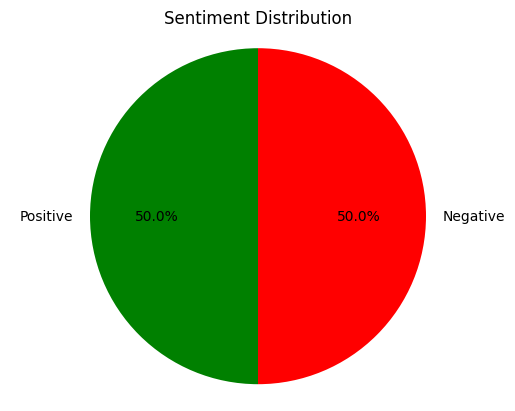

In [11]:
# Counting positive and negative reviews
positive_count = df['sentiment'].sum()  # summing the values in the 'sentiment' column to count the number of positive reviews
negative_count = len(df) - positive_count  # subtracting the number of positive reviews from the total number of reviews to get the number of negative reviews

# Creating data for pie chart
labels = ['Positive', 'Negative']  # assigning labels to each slice of the pie chart
sizes = [positive_count, negative_count]  # assigning the size of each slice based on the number of positive and negative reviews
colors = ['green', 'red']  # assigning colors to each slice of the pie chart

# Creating and plotting pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)  # creating the pie chart with the given parameters
plt.axis('equal')  # setting the x and y axis to be of equal length to make the chart circular
plt.title('Sentiment Distribution')  # setting the title of the chart
plt.show()  # displaying the chart

In [12]:
# Filter reviews based on sentiment
positive_reviews = ' '.join(df[df['sentiment'] == 1]['reviewText'])
negative_reviews = ' '.join(df[df['sentiment'] == 0]['reviewText'])

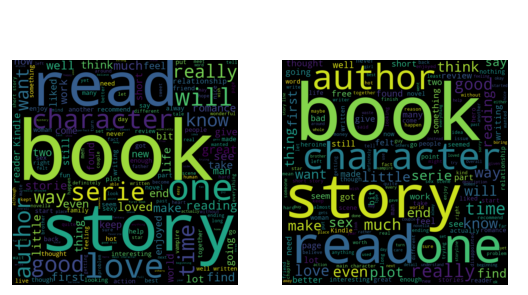

In [13]:
# Create a wordcloud for positive reviews
# set the background color to black and generate the wordcloud
wc_positive = WordCloud(width=800, height=800, background_color='black').generate(positive_reviews)

# create a subplot with 1 row, 2 columns, and index 1
plt.subplot(1, 2, 1)

# show the wordcloud image and remove the axis ticks
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')

# set the title of the subplot to 'Positive Reviews'
plt.title('Positive Reviews', color='white', fontsize=20, pad=20)

# Create a wordcloud for negative reviews
# set the background color to black and generate the wordcloud
wc_negative = WordCloud(width=800, height=800, background_color='black').generate(negative_reviews)

# create a subplot with 1 row, 2 columns, and index 2
plt.subplot(1, 2, 2)

# show the wordcloud image and remove the axis ticks
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')

# set the title of the subplot to 'Negative Reviews'
plt.title('Negative Reviews', color='white', fontsize=20, pad=20)

# display the plot
plt.show()

In [14]:
# Separating feature and target data
X = df['cleaned_review']  # Feature data (review text)
y = df['sentiment']   # Target data (sentiment labels)

In [15]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Tokenizing the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [17]:
# Padding the data
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [18]:
# Define the model architecture with an Embedding layer
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(units=512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with custom metrics and optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 512)               1312768   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,953,281
Trainable params: 1,953,281
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

start_time = time.time()
# Train the model with validation split and batch size
history = model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stop])

end_time = time.time()

Epoch 1/20
38/38 [==============================] - 31s 714ms/step - loss: 0.6933 - accuracy: 0.5065 - val_loss: 0.6930 - val_accuracy: 0.5038
Epoch 2/20
38/38 [==============================] - 27s 699ms/step - loss: 0.6929 - accuracy: 0.5079 - val_loss: 0.6937 - val_accuracy: 0.4958
Epoch 3/20
38/38 [==============================] - 27s 704ms/step - loss: 0.6925 - accuracy: 0.5082 - val_loss: 0.6928 - val_accuracy: 0.4963
Epoch 4/20
38/38 [==============================] - 26s 694ms/step - loss: 0.6920 - accuracy: 0.5067 - val_loss: 0.6924 - val_accuracy: 0.4954
Epoch 5/20
38/38 [==============================] - 26s 696ms/step - loss: 0.6893 - accuracy: 0.5191 - val_loss: 0.6862 - val_accuracy: 0.5454
Epoch 6/20
38/38 [==============================] - 26s 694ms/step - loss: 0.5847 - accuracy: 0.6826 - val_loss: 0.4784 - val_accuracy: 0.7746
Epoch 7/20
38/38 [==============================] - 26s 697ms/step - loss: 0.4311 - accuracy: 0.8093 - val_loss: 0.4272 - val_accuracy: 0.8146

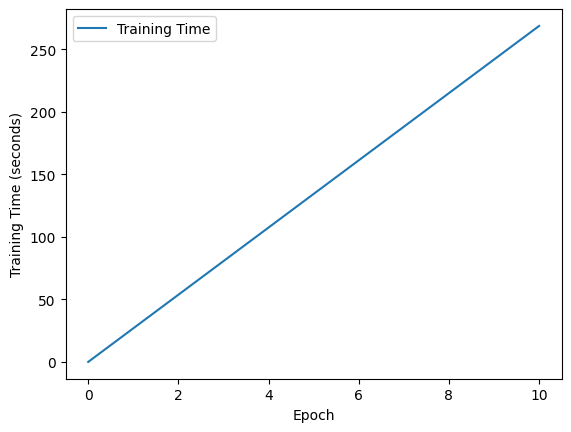

In [20]:
training_time_per_epoch = (end_time - start_time) / len(history.history['accuracy'])

# Plot training time graph
import matplotlib.pyplot as plt
plt.plot(history.epoch, [training_time_per_epoch * i for i in range(len(history.epoch))], label='Training Time')
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.show()

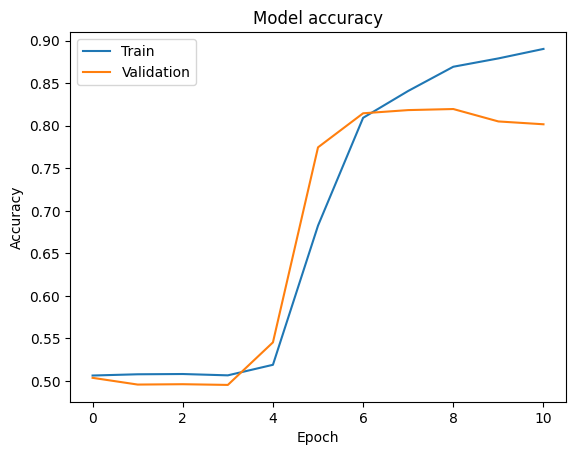

In [21]:
# Plot the validation training graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

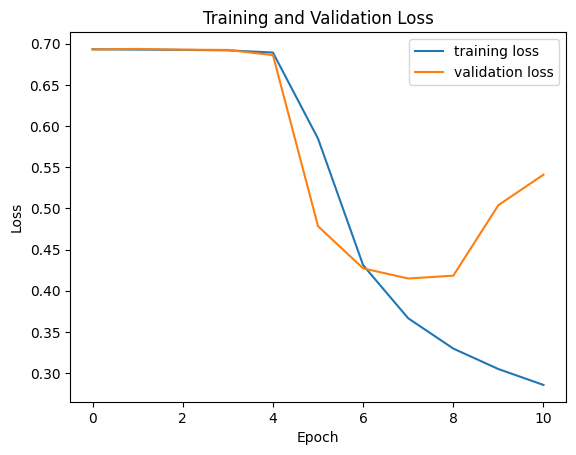

In [22]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# # Predict on validation sets
y_pred_val = model.predict(X_val)
y_pred_val = (y_pred_val > 0.5)

# Calculate evaluation metrics for validation set
print("Evaluation metrics for validation set:")
print(classification_report(y_val, y_pred_val))
auc_score_val = roc_auc_score(y_val, y_pred_val)
print("AUC:", auc_score_val)

75/75 [==============================] - 6s 66ms/step
Evaluation metrics for validation set:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1190
           1       0.76      0.88      0.82      1210

    accuracy                           0.80      2400
   macro avg       0.81      0.80      0.80      2400
weighted avg       0.81      0.80      0.80      2400

AUC: 0.8010209042294604


In [24]:
# Predict on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc_score)

75/75 [==============================] - 5s 65ms/step
Accuracy: 0.8016666666666666
Precision: 0.7636494252873564
Recall: 0.8785123966942149
F1 Score: 0.8170637970791699
AUC: 0.8010209042294604


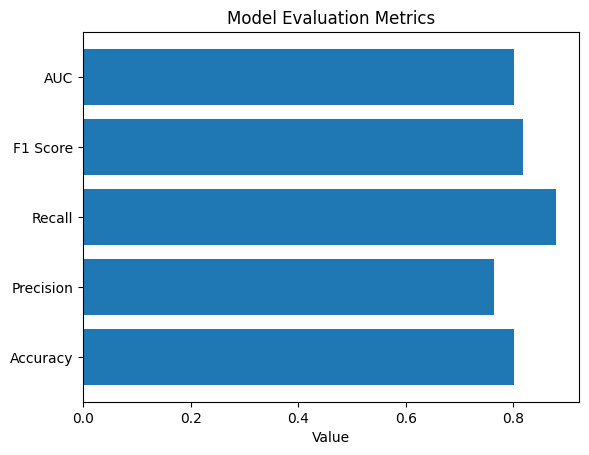

In [44]:
# Create a horizontal bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
values = [accuracy, precision, recall, f1, auc_score]
y_pos = np.arange(len(metrics))
plt.barh(y_pos, values)
plt.yticks(y_pos, metrics)
plt.xlabel('Value')
plt.title('Model Evaluation Metrics')
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Print the confusion matrix
print(cm)

75/75 [==============================] - 5s 63ms/step
[[ 861  329]
 [ 147 1063]]


In [26]:
from sklearn.metrics import confusion_matrix

# Get the predictions of the model on the test set
y_pred = model.predict(X_val)

# Convert the predictions to binary values (0 or 1) based on the threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

# Print the confusion matrix
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

75/75 [==============================] - 5s 65ms/step
True Negatives: 861
False Positives: 329
False Negatives: 147
True Positives: 1063


In [27]:
# [[TN  FP]
#  [FN  TP]]
# True positives (TP): The number of correctly predicted positive examples.
# True negatives (TN): The number of correctly predicted negative examples.
# False positives (FP): The number of negative examples that were incorrectly predicted as positive.
# False negatives (FN): The number of positive examples that were incorrectly predicted as negative.

75/75 [==============================] - 5s 63ms/step


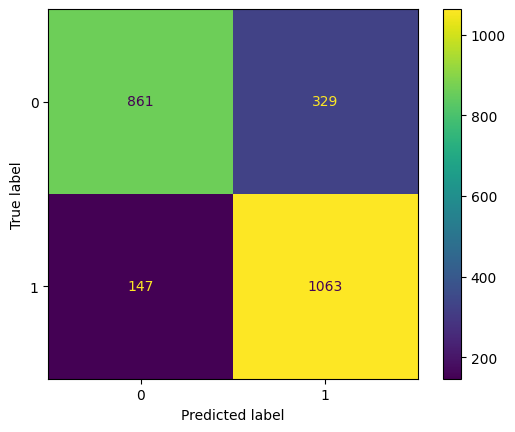

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot()
plt.show()

In [29]:
import transformers
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

In [30]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [31]:
#loading the preprocessed data for use in bert model
df_bert.sample(3)

,reviewText,rating,cleaned_review,sentiment
11892,"I give this story 4 stars, because the author ...",4,give story star author know keep reader attent...,1
6798,"Romance novel (rippling muscles, meaningful gl...",2,romance novel rippling muscle meaningful glanc...,0
308,Madeline `Maddie' Carpenter's life hasn't chan...,4,madeline maddie carpenter life changed since l...,1


In [32]:
# Separating feature and target data
X_bert = df_bert['cleaned_review']  # Feature data (review text)
y_bert = df_bert['sentiment']   # Target data (sentiment labels)

In [33]:
# Splitting data into training and testing sets
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(X_bert, y_bert, test_size=0.2, random_state=42)

In [34]:
# Tokenize and encode sequences
max_len = 100
X_train_bert = tokenizer(X_train_bert.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')
X_val_bert = tokenizer(X_val_bert.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')

In [35]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [36]:
# Freeze the BERT layers and add a classification layer
input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
bert_output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[1]
output = Dense(1, activation='sigmoid')(bert_output)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [37]:
# Freeze the BERT layers
bert_model.trainable = False

In [38]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [39]:
import time
from tensorflow.keras.callbacks import EarlyStopping

start_time = time.time()

history_bert = model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']],
    y_train_bert,
    batch_size=32,
    epochs=20,
    validation_data=([X_val_bert['input_ids'], X_val_bert['attention_mask']], y_val_bert),
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/20
300/300 [==============================] - 42s 120ms/step - loss: 0.6659 - accuracy: 0.5971 - val_loss: 0.6340 - val_accuracy: 0.6508
Epoch 2/20
300/300 [==============================] - 35s 116ms/step - loss: 0.6241 - accuracy: 0.6627 - val_loss: 0.6053 - val_accuracy: 0.6779
Epoch 3/20
300/300 [==============================] - 35s 116ms/step - loss: 0.6082 - accuracy: 0.6759 - val_loss: 0.5832 - val_accuracy: 0.7008
Epoch 4/20
300/300 [==============================] - 35s 116ms/step - loss: 0.5951 - accuracy: 0.6953 - val_loss: 0.5788 - val_accuracy: 0.7042
Epoch 5/20
300/300 [==============================] - 35s 116ms/step - loss: 0.5851 - accuracy: 0.7006 - val_loss: 0.5713 - val_accuracy: 0.7054
Epoch 6/20
300/300 [==============================] - 35s 116ms/step - loss: 0.5777 - accuracy: 0.7052 - val_loss: 0.5798 - val_accuracy: 0.6933
Epoch 7/20
300/300 [==============================] - 35s 116ms/step - loss: 0.5707 - accuracy: 0.7095 - val_loss: 0.5471 - val_ac

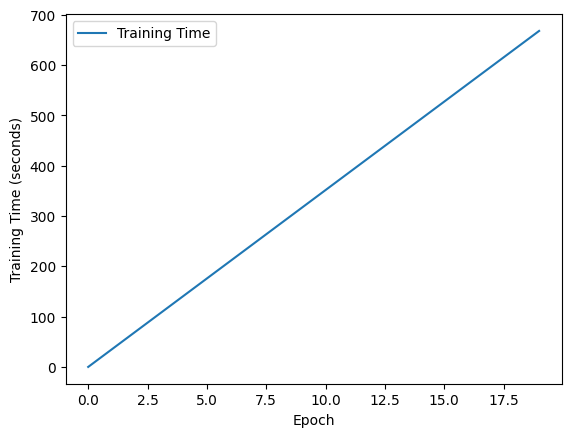

In [40]:
training_time_per_epoch = (end_time - start_time) / len(history_bert.history['accuracy'])

# Plot training time graph
plt.plot(history_bert.epoch, [training_time_per_epoch * i for i in range(len(history_bert.epoch))], label='Training Time')
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.show()

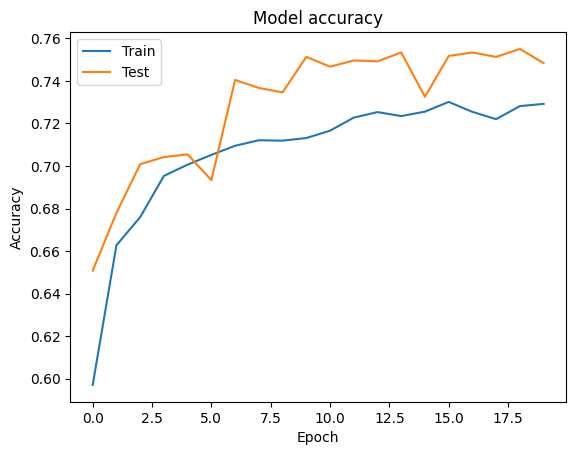

In [41]:
# Plot the validation training graph
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

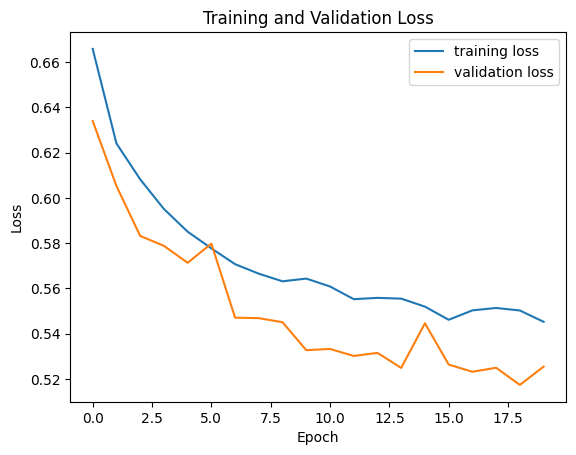

In [42]:
# Plot the training and validation loss
plt.plot(history_bert.history['loss'], label='training loss')
plt.plot(history_bert.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix

# Get the predictions of the model on the test set
y_pred = model.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']])

# Convert the predictions to binary values (0 or 1) based on the threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_val_bert, y_pred).ravel()

# Print the confusion matrix
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

75/75 [==============================] - 8s 86ms/step
True Negatives: 794
False Positives: 396
False Negatives: 208
True Positives: 1002


75/75 [==============================] - 6s 86ms/step


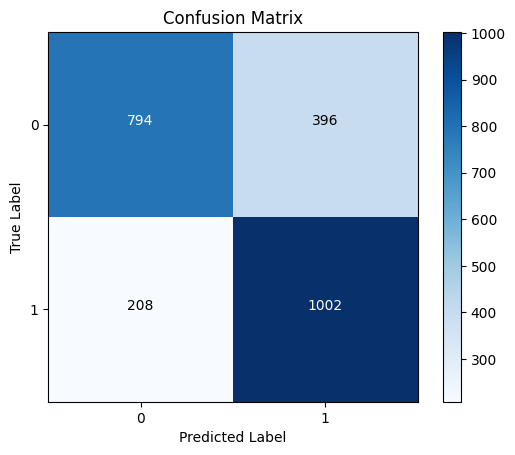

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions of the model on the test set
y_pred = model.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']])

# Convert the predictions to binary values (0 or 1) based on the threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_val_bert, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)

# Add axis labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add colorbar
plt.colorbar()

# Add ticks and tick labels
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

# Add values inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

In [49]:
# Get the predictions of the model on the validation set
y_pred = model.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']])

# Convert the predictions to binary values (0 or 1) based on the threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the evaluation metrics for the validation set
print("Evaluation metrics for the validation set:")
print(classification_report(y_val_bert, y_pred))
auc_score_val = roc_auc_score(y_val_bert, y_pred)
print("AUC:", auc_score_val)

75/75 [==============================] - 6s 86ms/step
Evaluation metrics for the validation set:
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      1190
           1       0.72      0.83      0.77      1210

    accuracy                           0.75      2400
   macro avg       0.75      0.75      0.75      2400
weighted avg       0.75      0.75      0.75      2400

AUC: 0.7476630321550107


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get the predictions of the model on the test set
y_pred = model.predict([X_val_bert['input_ids'], X_val_bert['attention_mask']])

# Convert the predictions to binary values (0 or 1) based on the threshold of 0.5
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Calculate the evaluation metrics
accuracy = accuracy_score(y_val_bert, y_pred)
precision = precision_score(y_val_bert, y_pred)
recall = recall_score(y_val_bert, y_pred)
f1 = f1_score(y_val_bert, y_pred)
auc_score = roc_auc_score(y_val_bert, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("AUC:", auc_score)

75/75 [==============================] - 6s 87ms/step
Accuracy: 0.7483333333333333
Precision: 0.7167381974248928
Recall: 0.828099173553719
F1 score: 0.7684049079754601
AUC: 0.7476630321550107


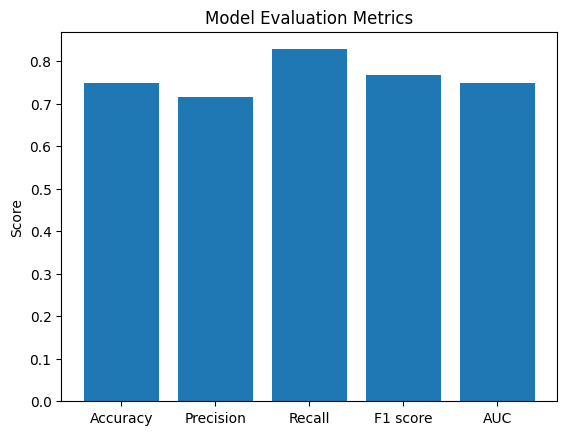

In [50]:
import matplotlib.pyplot as plt

# Create a list of metric names and a list of metric values
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC']
metric_values = [accuracy, precision, recall, f1, auc_score]

# Create a bar chart using matplotlib
fig, ax = plt.subplots()
ax.bar(metric_names, metric_values)

# Add labels and a title to the chart
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')

# Show the chart
plt.show()